In [1]:

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

In [6]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        data = os.listdir(self.data_dir)

        img_list, label_list = [], []
        for f in sorted(data):
            if 'sample' in f:
                img_list.append(f) 
            elif 'label' in f:
                label_list.append(f)

        self.img_list = img_list
        self.label_list = label_list

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, index):

        input = Image.open(os.path.join(self.data_dir, self.img_list[index]))
        label = Image.open(os.path.join(self.data_dir, self.label_list[index])).convert("L")
        
        input, label = np.array(input), np.array(label)

        input, label = input/255.0, label/255.0
        input, label = input.astype(np.float32), label.astype(np.float32)

        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        if self.transform:
            data = self.transform(data)

        return data

In [7]:
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

In [8]:
data_dir = '/mnt/hdd1/c-MET_datasets/Lung_c-MET IHC_scored/DL-based_tumor_seg_dataset'

batch_size = 16

transform_train = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
dataset_train = Dataset(data_dir=os.path.join(data_dir,'train'),transform = transform_train)

loader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)

In [9]:
for batch, data in enumerate(loader_train,1): # 1은 뭐니 > index start point
        # forward
        label = data['label']  # 데이터 device로 올리기     
        inputs = data['input']

        if batch == 1:
                break

In [11]:
inputs.size()

torch.Size([16, 3, 256, 256])

# RandomFlip

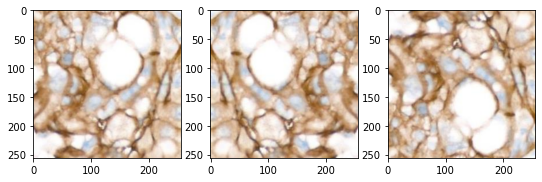

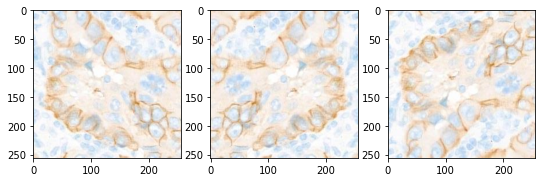

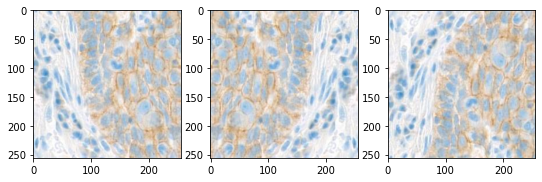

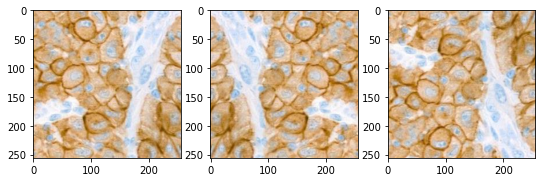

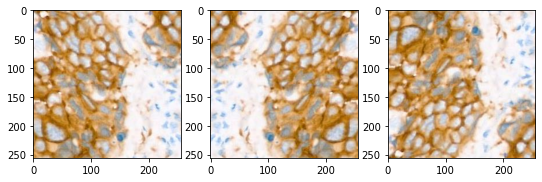

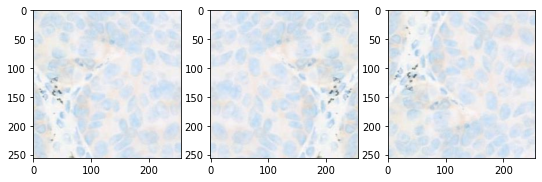

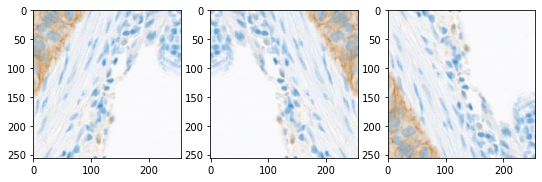

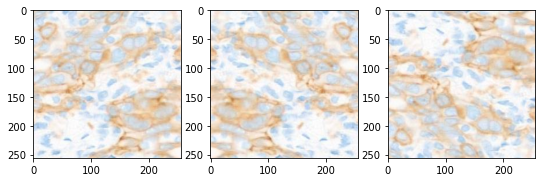

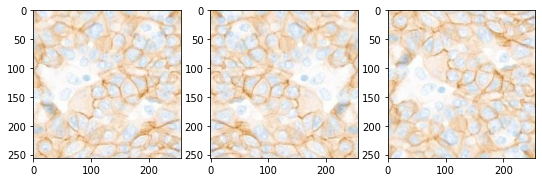

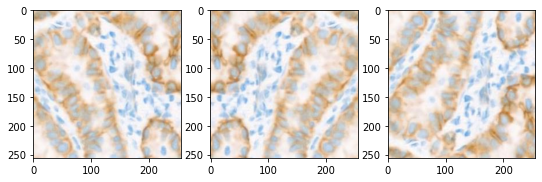

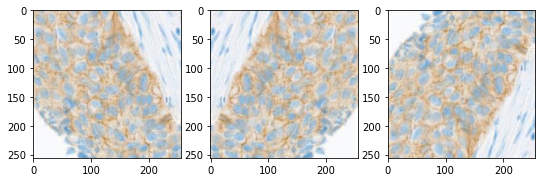

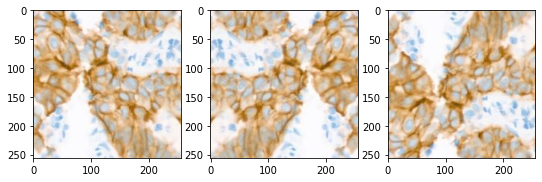

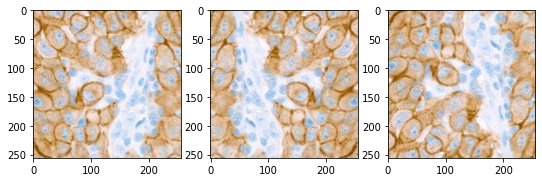

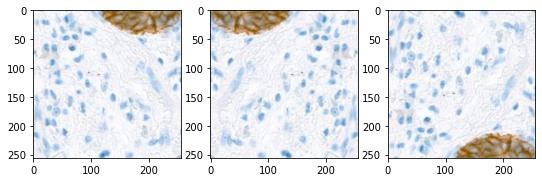

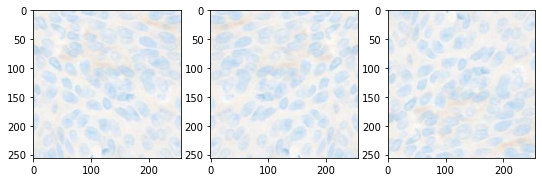

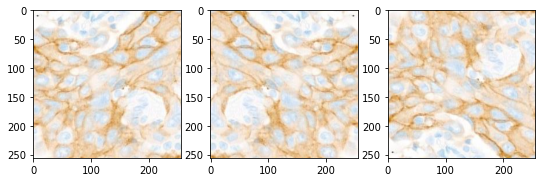

In [17]:
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(1, 2, 0)
fn_denorm = lambda x, mean, std : (x*std) + mean

for i in range(len(inputs)):

    img = fn_denorm(fn_tonumpy(inputs[i]), mean=0.5, std=0.5)

    plt.figure(figsize = (9, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.fliplr(img))

    plt.subplot(1, 3, 3)
    plt.imshow(np.flipud(img))
    plt.show()


# Partial non-tissue

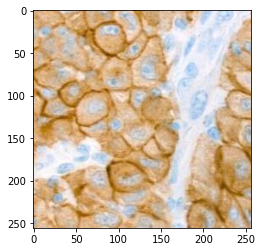

In [70]:
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(1, 2, 0)
fn_denorm = lambda x, mean, std : (x*std) + mean

i = 3
img = fn_denorm(fn_tonumpy(inputs[i]), mean=0.5, std=0.5)
lab = fn_tonumpy(label[i])

plt.imshow(img)
plt.show()

In [71]:
0.96*255 + 0.01*255*np.random.randn()

243.43807923106846

1


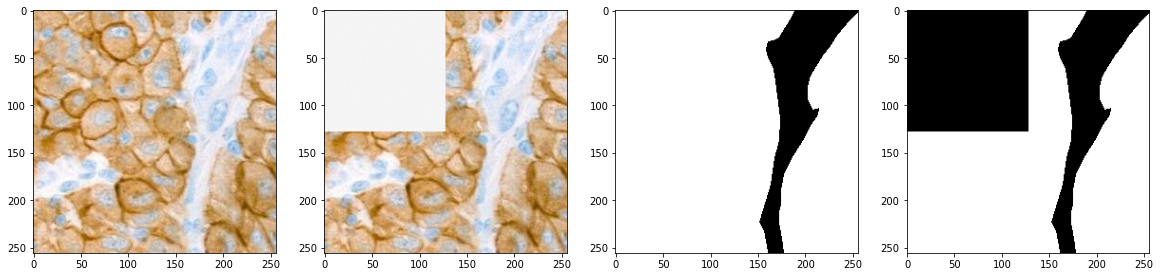

In [76]:
height, width, ch = img.shape
half_size = height//2 
img_ = img.copy()
lab_ = lab.copy()
non_tissue = np.clip((0.96*np.ones((half_size, half_size, ch)) + 0.005*np.random.randn(half_size, half_size, ch)), a_min = 0, a_max = 1)
non_tissue_mask = np.zeros((half_size, half_size, 1))

rotation = np.random.randint(1, 5) 
if rotation == 1:
    img_[:half_size, :half_size, :] = non_tissue
    lab_[:half_size, :half_size, :] = non_tissue_mask
elif rotation == 2:
    img_[:half_size, half_size:, :] = non_tissue
    lab_[:half_size, half_size:, :] = non_tissue_mask
elif rotation == 3:
    img_[half_size:, :half_size, :] = non_tissue
    lab_[half_size:, :half_size, :] = non_tissue_mask
elif rotation == 4:
    img_[:half_size, :half_size, :] = non_tissue
    lab_[:half_size, :half_size, :] = non_tissue_mask

print(rotation)

plt.figure(figsize = (20, 6))

plt.subplot(1, 4, 1)
plt.imshow(img)

plt.subplot(1, 4, 2)
plt.imshow(img_)

plt.subplot(1, 4, 3)
plt.imshow(lab, cmap = 'gray')

plt.subplot(1, 4, 4)
plt.imshow(lab_, cmap = 'gray')
plt.show()

In [ ]:
class PartialNonTissue(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        size, size, ch = input.shape
        half_size = size//2 

        non_tissue = np.clip((0.96*np.ones((half_size, half_size, ch)) + \
                             0.005*np.random.randn(half_size, half_size, ch)), 
                             a_min = 0, a_max = 1)
        non_tissue_mask = np.zeros((half_size, half_size, 1))

        if np.random.randint(1, 5) == 1:
            rotation = np.random.randint(1, 5) 
            if rotation == 1:
                input[:half_size, :half_size, :] = non_tissue
                label[:half_size, :half_size, :] = non_tissue_mask
            elif rotation == 2:
                input[:half_size, half_size:, :] = non_tissue
                label[:half_size, half_size:, :] = non_tissue_mask
            elif rotation == 3:
                input[half_size:, :half_size, :] = non_tissue
                label[half_size:, :half_size, :] = non_tissue_mask
            elif rotation == 4:
                input[:half_size, :half_size, :] = non_tissue
                label[:half_size, :half_size, :] = non_tissue_mask

        data = {'label': label, 'input': input}

        return data